## Caution
Shoud I consider the guard time?

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from Cyclist_env_RDA_2nano import cyclist_env
from time import time
from scipy.fft import fft, ifft
from scipy.linalg import dft

import torch
import pandas as pd
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment

### Coefficients

In [9]:
###### symbol time & carrier frequency ######
T_symbol = 5.575 * 1e-6              # symbol duration, with CP time
T_OFDM = 5.2125 * 1e-6
f_carrier = 28 * 1e+9
Tc = 2.545*1e-9                      # sampling time

###### tx/rx ######
N_ant = 16                       # the number of antennas
# BW = 1.966080e+9                      # chirp bandwidth
BW = 400*1e+6                    # chirp bandwidth
BW_sub = BW/N_ant
N_sample = int(np.floor(T_symbol/Tc))           # the number of samples of single chirp
rx_sample = 813 + N_sample

T_trans = rx_sample * Tc
print("一回のセンシングに要する時間:", T_trans)

###### Radar setting ######

mu = BW_sub/T_symbol * 0.98

l_speed = 299792458

env = cyclist_env(f_carrier, N_ant, BW, BW_sub, N_sample, rx_sample, Tc, mu, l_speed)

一回のセンシングに要する時間: 7.642635000000001e-06


In [11]:
def stevec(N_ant, angle):
    resp = (np.arange(N_ant)-N_ant*0.5+0.5).reshape([-1,1])
    resp = np.exp(1j*resp*np.pi*np.sin(angle))
    return np.matrix(resp)

In [13]:
## Here is the point to change. like draw some values for the position of the vehicle, and put it out that here.
## the I guess there is efficient way to merge the delayed versions of the waveform.
## for right now, just forget about the efficiency, just code it.
## All you care about is the Doppler.
## There is some value I cut off.
x_pos = list(np.arange(-450, -149)/10)
p_bs = np.array([250, -18, 50])


# num_cy = np.random.randint(1, 3)
num_cy = 1

cy_idx = np.zeros(num_cy, dtype=np.int32)
p_cy, v_cy = np.zeros((num_cy, 3)), np.zeros((num_cy, 3))
i=0
s = set()
while i < num_cy:
    idx = np.random.randint(0, 301, 1)[0]
    # idx = 0
    
    if idx+10 in s or idx-10 in s or idx in s: continue
    for j in range(-20,20): s.add(idx+j)
    cy_idx[i] = idx
    p_cy[i] = np.array([x_pos[idx], 15, 1])
    # v_cy[i] = np.array([np.random.rand(1)[0]*5.56, 0, 0])
    v_cy[i] = np.array([0, 0, 0])
    
    i+=1
n_cy = len(p_cy)


# num_ve = np.random.randint(1, 3)
num_ve = 1

ve_idx = np.zeros(num_ve, dtype=np.int32)
p_ve, v_ve = np.zeros((num_ve, 3)), np.zeros((num_ve, 3))

s = set()
i=0
while i < num_ve:
    idx = np.random.randint(0, 301, 1)[0]
    # idx = 0
    
    if idx+20 in s or idx-20 in s or idx in s: continue
    for j in range(-20,20): s.add(idx+j)
    ve_idx[i] = idx
    p_ve[i] = np.array([x_pos[idx], 7.5, 1])
    # v_ve[i] = np.array([np.random.rand(1)[0]*11.11, 0, 0])
    v_ve[i] = np.array([0, 0, 0])
    
    i+=1

n_rp = 0

p_rp, v_rp = np.zeros((n_rp, 3)), np.zeros((n_rp, 3))

# p_rp[0] = np.array([-17.5, 17.8, 1])
# p_rp[1] = np.array([-27.5, 17.8, 1])
# p_rp[2] = np.array([-37.5, 17.8, 1])


n_ve = len(p_ve)
cy_idx += 1
ve_idx += 1
print(p_cy)
print('-------------')
print(p_ve)
print('-------------')
print(p_rp)

P_rx_cy, tstemp_rx_cy, phase_cy, P_rx_ve, tstemp_rx_ve, phase_ve, P_rx_rp, tstemp_rx_rp, phase_rp = [], [], [], [], [], [], [], [], []
for i in range(len(cy_idx)):
    df = pd.read_csv("./ped/2.545nano/far/complex-impulse-response-Run{:04d}-Sensor_0_Tx_0_to_Rx_0.csv".format(cy_idx[i]))
    tstemp_rx_cy.append(np.ceil((df["Time (s)"]/Tc).values[3:]))
    P_rx_cy.append(df["| Total Complex Impulse Response total | (W)"].values[3:])
    phase_cy.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[3:])
for i in range(len(ve_idx)):
    df = pd.read_csv("./vehicle/2.545nano/far/complex-impulse-response-Run{:04d}-Sensor_0_Tx_0_to_Rx_0.csv".format(ve_idx[i]))
    tstemp_rx_ve.append(np.ceil((df["Time (s)"]/Tc).values[3:]))
    P_rx_ve.append(df["| Total Complex Impulse Response total | (W)"].values[3:])
    phase_ve.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[3:])
#for i in range(1,4):
#    df = pd.read_csv("./Ramposts/"+str(i)+"/complex-impulse-response-Run0001-Sensor_0_Tx_0_to_Rx_0.csv")
#    tstemp_rx_rp.append(np.ceil((df["Time (s)"]/Tc).values[5:]))
#    P_rx_rp.append(df["| Total Complex Impulse Response total | (W)"].values[5:])
#    phase_rp.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[5:])

phys_quantities = env.phys_quantities(p_bs, p_cy, v_cy, n_cy, p_ve, v_ve, n_ve, p_rp, v_rp, n_rp)
tx = env.tx()

######### We need some functions here. it is like this. read the csv. this outputs the time stemp and corresponding rx value.
# P_rx_cy_dB = -114
#P_rx_cy_dB = -111
#P_rx_ve_dB = -114
#P_rx_cy_dB = 0
#P_rx_ve_dB =5
P_N_dB = -87.98 # target noise power when using 2GHz BW

N_trans = 200
sym_duration = rx_sample*Tc
Y = env.rx_multiple(tx, P_rx_cy, tstemp_rx_cy, phase_cy, P_rx_ve, tstemp_rx_ve, phase_ve, P_rx_rp, tstemp_rx_rp, phase_rp, P_N_dB, sym_duration, N_trans)
    



[[-26.9  15.    1. ]]
-------------
[[-44.2   7.5   1. ]]
-------------
[]


In [14]:

Y_music = np.mean(Y, axis=0)
R_yy = Y_music@np.conjugate(np.transpose(Y_music))
# print(np.linalg.eig(R_yy)[0])
U = np.linalg.eig(R_yy)[1][:,5:]

resp = []
argm = (np.arange(1800)-900)/100
for val in argm:
    stv = stevec(N_ant, val*np.pi/180)
    p = stv.T@U
    pp = p*np.conjugate(np.transpose(p))
    resp.append(1/(np.abs(pp)**2).A1)


cy_ang = env.result['angle']['cyclists']/np.pi*180
ve_ang = env.result['angle']['vehicles']/np.pi*180
rp_ang = env.result['angle']['ramposts']/np.pi*180

M = max(resp)
est_ang = []

a, b = resp[0][0], resp[1][0]
for i in range(1,len(argm)-1):
    c = resp[i+1][0]
    if a < b and b > c and b > 0.2 * M:
        est_ang.append(argm[i])
    a, b = b, c

print(est_ang)
print(env.result['angle']['cyclists'] /np.pi*180)
print(env.result['angle']['vehicles'] /np.pi*180)
est_ang = [est_ang[0]]



[np.float64(1.41)]
[3.24705901]
[1.4045708]


[283.1317891] [0.] [0.]
[299.340759] [0.] [0.]


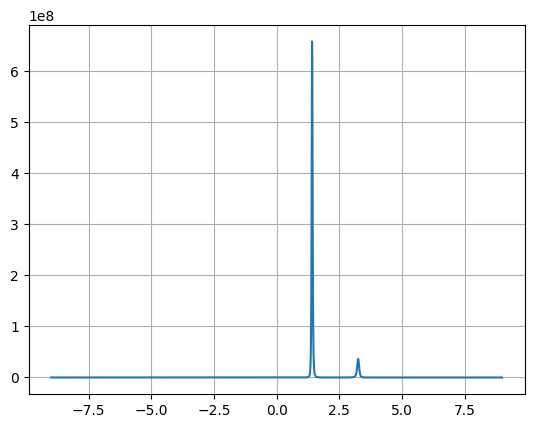

In [15]:
plt.plot(argm, resp), plt.grid()
print(np.array(env.result['range']['cyclists']), np.array(env.result['relative_velocity']['cyclists'])*3600/1000, np.array(env.result['relative_velocity']['cyclists']))
print(np.array(env.result['range']['vehicles']), np.array(env.result['relative_velocity']['vehicles'])*3600/1000, np.array(env.result['relative_velocity']['vehicles']))

In [16]:
Dopp_dft = dft(N_trans)/np.sqrt(N_trans)
Y_dft = np.zeros((N_trans, N_ant, rx_sample), dtype=np.complex128)
for i in range(N_ant):
    Y_dft[:,i,:] = Dopp_dft@Y[:,i,:]
val, res, rdresp = 0, [], np.zeros((N_trans,190), dtype=np.complex128)
Q = 1
P_range = np.arange(190) + 620
pretime = time()
for i in range(len(est_ang)):
    ang = est_ang[i]*np.pi/180
    dup = np.ones((N_trans, 1, 1), dtype=np.complex128)
    for p in P_range:
        X_cand = np.zeros((N_ant, rx_sample), dtype=np.complex128)
        last = min(p+N_sample, rx_sample)
        X_cand[:,p:last] += tx[:,:last-p]
        g = np.conjugate(stevec(N_ant, ang))@np.conjugate(np.transpose(stevec(N_ant, ang)))@X_cand
        g_mat = dup*np.array(g)
        metric = np.sum(np.multiply(np.conjugate(Y_dft), g_mat), axis=(1,2))
        rdresp[:,p-620] = metric
# np.save('./Data_withfewtargetsandobstacles/'+str(indexindex)+'.npy',rdresp)


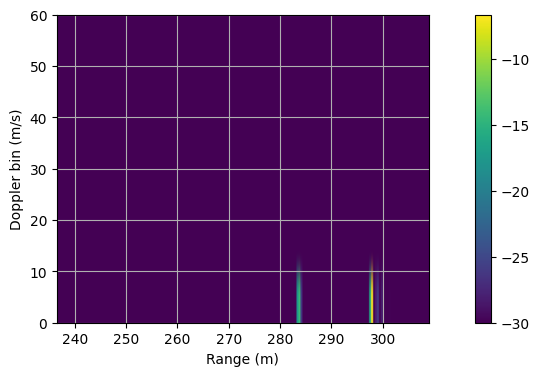

In [17]:
output = rdresp[:100,:] + 1e-10
plt.figure(figsize=(12,4))
plt.imshow(20*np.log10(abs(output)), vmin = -30, extent=[236.52,309.00,0,1/T_symbol*l_speed/f_carrier/2], origin='lower')
# plt.imshow(20*np.log10(abs(output)), vmin = -20
# plt.ylim(0,30)
# plt.xlim(210,249)
plt.ylim(0,60)
# plt.xlim(140,175)
plt.xlabel('Range (m)')
plt.ylabel('Doppler bin (m/s)')
plt.colorbar()
plt.grid()


i+=1

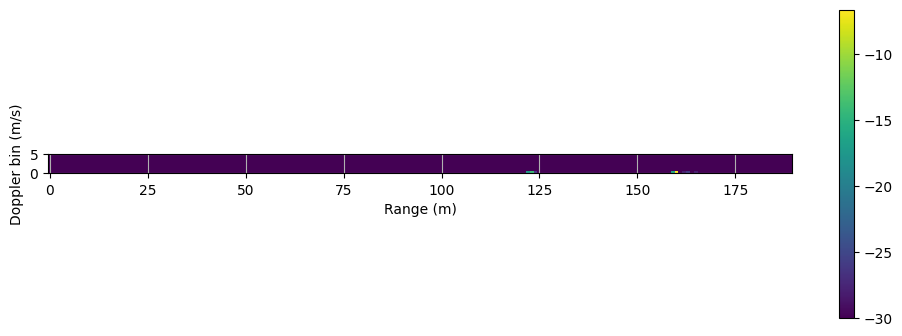

In [18]:
output = rdresp[:100,:] + 1e-10
plt.figure(figsize=(12,4))
plt.imshow(20*np.log10(abs(output)), vmin = -30, origin='lower')
# plt.imshow(20*np.log10(abs(output)), vmin = -20)
# plt.ylim(0,30)
# plt.xlim(210,249)
plt.ylim(0,5)
# plt.xlim(160, 170)
plt.xlabel('Range (m)')
plt.ylabel('Doppler bin (m/s)')
plt.colorbar()
plt.grid()
i+=1

In [19]:
def ca_cfar_2d(x_db, n_train=(12,7), n_guard=(3,3), pfa=1e-6, convert_from_db=False):
    """
    x_db: (B,1,H,W) input map (dB or linear)
    n_train: (th, tw) training half window size
    n_guard: (gh, gw) guard half window size
    """
    if convert_from_db:
        x = 10 ** (x_db / 10.0)  # dB -> linear
    else:
        x = x_db

    B, C, H, W = x.shape
    th, tw = n_train
    gh, gw = n_guard

    # Total kernel size
    kh = 2 * (th + gh) + 1
    kw = 2 * (tw + gw) + 1

    # Make training mask
    kernel = torch.ones((1,1,kh,kw), device=x.device)
    kernel[:, :, th-gh:th+gh+1, tw-gw:tw+gw+1] = 0  # guard + CUT = 0

    N_train = kernel.sum().item()
    alpha = N_train * (pfa ** (-1.0 / N_train) - 1.0)

    # Convolution = training sum
    x_pad = F.pad(x, (kw//2, kw//2, kh//2, kh//2), mode="reflect")
    train_sum = F.conv2d(x_pad.double(), kernel.double())
    noise_est = train_sum / N_train

    threshold = alpha * noise_est
    detections = x > threshold
    return detections, threshold, noise_est

In [20]:
def thresholder(radar, idx, tar_thres = 0.03, cyvethres = 0.22):
    cy_idx, ve_idx = [], []
    radar = radar
    for i in range(len(idx)):
        idx_y, idx_x = idx[i]
        rangeofinterest = radar[0:5, max(0, idx_x-2):min(idx_x+2, 190)].flatten()
        top2 = rangeofinterest.topk(2).values.mean()
        if top2 > tar_thres:
            cy_idx.append(idx_x)
    cy_idx_cleans = cleansing(cy_idx)
    # ve_idx_cleans = cleansing(ve_idx)

    return cy_idx_cleans

In [21]:
def cleansing(idx, tol=5):
    if idx :
        res = [idx[0]]
        for i in range(1,len(idx)):
            if idx[i]<=idx[i-1]+tol:
                continue
            res.append(idx[i])
        return res
    else: return []

In [22]:
def match_classwise(pred_x, gt_x):
    """
    pred_x : np.array of shape (N_pred,)
    gt_x   : np.array of shape (N_gt,)
    Returns: (matches, unmatched_pred_idx, unmatched_gt_idx)
    """
    if len(pred_x) == 0:
        return [], list(range(len(pred_x))), list(range(len(gt_x)))
    if len(gt_x) == 0:
        return [], list(range(len(pred_x))), list(range(len(gt_x)))

    cost = np.abs(pred_x[:, None] - gt_x[None, :])
    row_ind, col_ind = linear_sum_assignment(cost)

    matches = [(r, c) for r, c in zip(row_ind, col_ind)]
    unmatched_pred = [i for i in range(len(pred_x)) if i not in row_ind]
    unmatched_gt   = [j for j in range(len(gt_x)) if j not in col_ind]

    return matches, unmatched_pred, unmatched_gt


In [23]:
def absdiscal(res, pred, gt, target):
    cal = []
    y_val = 15 if target =='cy' else 7.5

    for i,j in res:
        # print(i,j)
        d_pred = (pred[i]+620)*Tc*l_speed/2
        d_gt = (gt[j]+620)*Tc*l_speed/2
        cal.append(abs(d_pred-d_gt))
    return cal

In [24]:
radar_in = torch.tensor(abs(rdresp))

In [25]:
thres = 0.22
pretime = time()
radar_in = radar_in.clone().detach()
detections, _, _ = ca_cfar_2d(radar_in.unsqueeze(0).unsqueeze(0), convert_from_db=False)

idxex = []
for i in range(N_trans):
    idx_est = torch.nonzero(detections[0,0,i], as_tuple=True)[0].tolist()
    for j in range(len(idx_est)):
        idxex.append((i, idx_est[j]))
cy_idxs_pred, ve_idxs_pred = thresholder(radar_in, idxex, tar_thres=0.05, cyvethres = thres)


In [ ]:
def Radar_setting():
    ###### symbol time & carrier frequency ######
    T_symbol = 5.575 * 1e-6              # symbol duration, with CP time
    T_OFDM = 5.2125 * 1e-6
    f_carrier = 28 * 1e+9
    Tc = 2.545*1e-9                      # sampling time

    ###### tx/rx ######
    N_ant = 16                       # the number of antennas
    # BW = 1.966080e+9                      # chirp bandwidth
    BW = 400*1e+6                    # chirp bandwidth
    BW_sub = BW/N_ant
    N_sample = int(np.floor(T_symbol/Tc))           # the number of samples of single chirp
    rx_sample = 813 + N_sample

    T_trans = rx_sample * Tc

    ###### Radar setting ######

    mu = BW_sub/T_symbol * 0.98

    l_speed = 299792458

    lam = c/f_carrier

    env = cyclist_env(f_carrier, N_ant, BW, BW_sub, N_sample, rx_sample, Tc, mu, l_speed)
    return T_symbol,f_carrier,Tc,N_ant,BW,BW_sub,N_sample,rx_sample, T_trans, mu, l_speed, lam, env

In [ ]:
def Sim_Setting():
    # シミュレーション設定
    p_bs = np.array([250, -18, 50])                         #基地局の位置

    # 各車両の数
    num_cy = 1
    num_ve = 0
    num_rp = 0
    # シミュレーション範囲の設定
    #start_cy_idx = 135
    #start_ve_idx = 150
    start_cy_idx = 75
    start_ve_idx = 50

    #end_cy_idx = 300
    #end_ve_idx = 3
    end_cy_idx = 135
    end_ve_idx = 150

    cy_interval = 3
    ve_interval = 5

    cy_v_value = 6
    ve_v_value = 10
    return p_bs, num_cy, num_ve, num_rp, start_cy_idx, start_ve_idx, end_cy_idx, end_ve_idx, cy_v_value, ve_v_value

In [ ]:
def syntax_check(num, idx, y_value, velocity_value, x_pos):
    idx_list = np.zeros(num, dtype=np.int32)
    position, velocity = np.zeros((num, 3)), np.zeros((num, 3))
    i=0
    s = set()
    while i < num:
        # 初期値における距離間隔を保証するための処理
        if idx+10 in s or idx-10 in s or idx in s: continue
        for j in range(-20,20): s.add(idx+j)
        
        idx_list[i] = idx
        position[i] = np.array([x_pos[idx], y_value, 1])
        # v_cy[i] = np.array([np.random.rand(1)[0]*5.56, 0, 0])
        velocity[i] = np.array([velocity_value, 0, 0])
        
        i+=1
    return idx_list, position, velocity

In [ ]:
def get_snapshot_data(cy_idx_target, ve_idx_target,x_pos, p_bs, tx, cy_v_value, ve_v_value, num_cy, num_ve, num_rp):
    # Cyclistについて
    cy_idx = np.zeros(num_cy, dtype=np.int32)
    p_cy, v_cy = np.zeros((num_cy, 3)), np.zeros((num_cy, 3))
    # 範囲外アクセスを防ぐための処理
    cy_idx, p_cy, v_cy = syntax_check(num_cy, cy_idx_target, 15, cy_v_value, x_pos)
    n_cy = len(p_cy)
    
    # Vehicleについて
    ve_idx = np.zeros(num_ve, dtype=np.int32)
    p_ve, v_ve = np.zeros((num_ve, 3)), np.zeros((num_ve, 3))
    # 範囲外アクセスを防ぐための処理
    ve_idx, p_ve, v_ve = syntax_check(num_ve, ve_idx_target, 7.5, ve_v_value, x_pos)
    n_ve = len(p_ve)

    # ramppostについて
    p_rp, v_rp = np.zeros((num_rp, 3)), np.zeros((num_rp, 3))
    n_rp = len(p_rp)
    
    # csvファイルの読み込み
    cy_idx += 1
    ve_idx += 1

    P_rx_cy, tstemp_rx_cy, phase_cy, P_rx_ve, tstemp_rx_ve, phase_ve, P_rx_rp, tstemp_rx_rp, phase_rp = [], [], [], [], [], [], [], [], []
    # 3番目のデータから読み込み開始（最初の数個はノイズのみのため）
    for i in range(len(cy_idx)):
        df = pd.read_csv("./ped/0.5nano/complex-impulse-response-Run{:04d}-Sensor_0_Tx_0_to_Rx_0.csv".format(cy_idx[i]))
        tstemp_rx_cy.append(np.ceil((df["Time (s)"]/Tc).values[3:]))                            #サンプル時間で割ることでサンプルインデックスに変換
        P_rx_cy.append(df["| Total Complex Impulse Response total | (W)"].values[3:])
        phase_cy.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[3:])
    for i in range(len(ve_idx)):
        df = pd.read_csv("./vehicle/0.5nano/complex-impulse-response-Run{:04d}-Sensor_0_Tx_0_to_Rx_0.csv".format(ve_idx[i]))
        tstemp_rx_ve.append(np.ceil((df["Time (s)"]/Tc).values[3:]))
        P_rx_ve.append(df["| Total Complex Impulse Response total | (W)"].values[3:])
        phase_ve.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[3:])
    for i in range(1,4):
        df = pd.read_csv("./Ramposts/"+str(i)+"/complex-impulse-response-Run0001-Sensor_0_Tx_0_to_Rx_0.csv")
        tstemp_rx_rp.append(np.ceil((df["Time (s)"]/Tc).values[5:]))
        P_rx_rp.append(df["| Total Complex Impulse Response total | (W)"].values[5:])
        phase_rp.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[5:])
        
    phys_quantities = env.phys_quantities(p_bs, p_cy, v_cy, n_cy, p_ve, v_ve, n_ve, p_rp, v_rp, n_rp)
    real_cy_coordinates = []
    real_vel_coordinates = []
    for i in range(len(p_cy)):
        real_cy_coordinates.append(np.array([p_cy[i][0], p_cy[i][1]]))
    for i in range(len(p_ve)):
        real_vel_coordinates.append(np.array([p_ve[i][0], p_ve[i][1]]))
        
    ######### We need some functions here. it is like this. read the csv. this outputs the time stemp and corresponding rx value.
    # P_rx_cy_dB = -114
    #P_rx_cy_dB = -111
    #P_rx_ve_dB = -114
    #P_rx_cy_dB = 0
    #P_rx_ve_dB = 0
    
    P_N_dB = -81 # target noise power when using 2GHz BW

    sym_duration = rx_sample*Tc

    Y = env.rx_multiple(tx, P_rx_cy, tstemp_rx_cy, phase_cy, P_rx_ve, tstemp_rx_ve, phase_ve, P_rx_rp, tstemp_rx_rp, phase_rp, P_N_dB, sym_duration, N_trans)
    
    return Y, phys_quantities, real_cy_coordinates, real_vel_coordinates

#x_pos = list(np.arange(-450, -149)/10)
#p_bs = np.array([250, -18, 50])
#Y, phys_quantities = get_snapshot_data(100,0,x_pos,p_bs)

In [ ]:
# 実行用
T_symbol,f_carrier,Tc,N_ant,BW,BW_sub,N_sample,rx_sample, T_trans, mu, l_speed, lam, env = Radar_setting()
N_chirp = 200
N_trans = N_chirp
tx = env.tx()
p_bs, num_cy, num_ve, num_rp, start_cy_idx, start_ve_idx, end_cy_idx, end_ve_idx, cy_v_value, ve_v_value = Sim_Setting()
cy_idx, ve_idx = start_cy_idx, start_ve_idx
measurement_history = []
frame_count = 0